In [24]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [9]:
facilities_gdf = gpd.read_file("/Users/theodoreutomo/algoverse-research-project/data/raw/healthcarefac/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp")

# Load the population density raster (TIF)
raster_path = "/Users/theodoreutomo/algoverse-research-project/data/raw/population/KEN_population_v1_0_gridded.tif"
with rasterio.open(raster_path) as src:
    pop_density = src.read(1)
    raster_crs = src.crs
    raster_bounds = src.bounds

# Load the roads shapefile
roads_gdf = gpd.read_file("/Users/theodoreutomo/algoverse-research-project/data/raw/roads/KEN_Roads/KEN_Roads.shp")

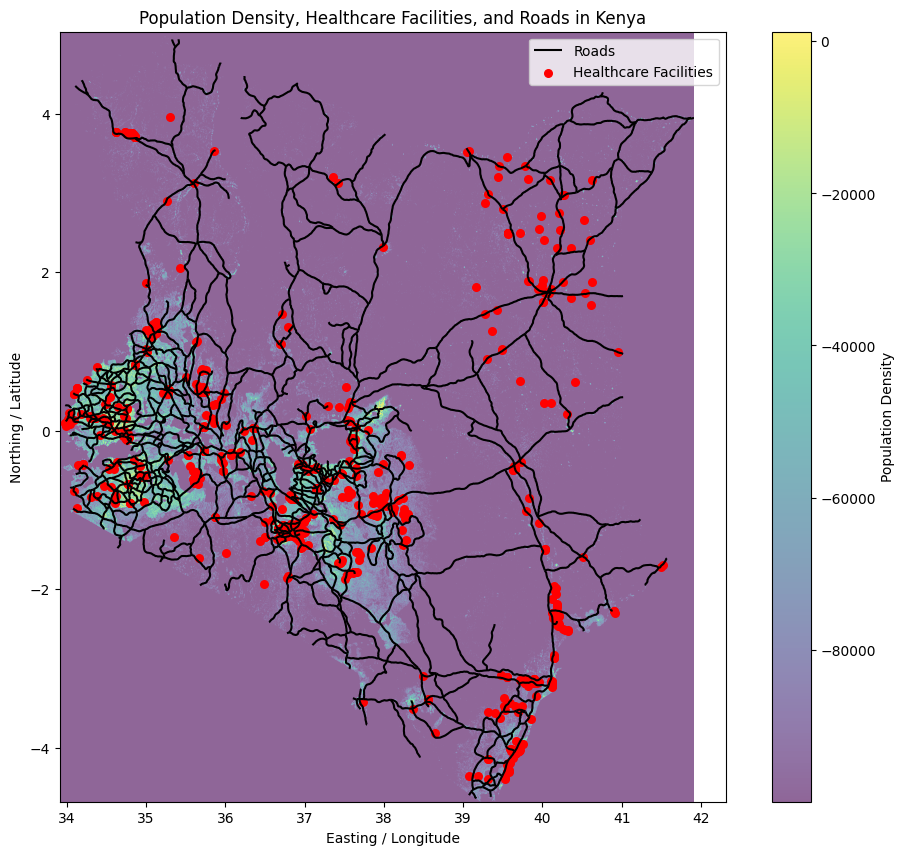

In [10]:
# Check if the roads data has a CRS; if not, set it manually
if roads_gdf.crs is None:
    # Replace "EPSG:4326" with the actual CRS if different
    roads_gdf = roads_gdf.set_crs("EPSG:4326")


facilities_gdf = facilities_gdf.to_crs(raster_crs)
roads_gdf = roads_gdf.to_crs(raster_crs)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the population density raster with proper extent.
extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top]
img = ax.imshow(pop_density, extent=extent, cmap='viridis', alpha=0.6)
cbar = plt.colorbar(img, ax=ax)
cbar.set_label("Population Density")

# Overlay roads on the map.
roads_gdf.plot(ax=ax, color='black', linewidth=1.5, label='Roads')

# Overlay healthcare facilities on the map.
facilities_gdf.plot(ax=ax, marker='o', color='red', markersize=30, label='Healthcare Facilities')

# Add title and labels.
ax.set_title("Population Density, Healthcare Facilities, and Roads in Kenya")
ax.set_xlabel("Easting / Longitude")
ax.set_ylabel("Northing / Latitude")
ax.legend(loc='upper right')

plt.show()

/var/folders/v0/wy271jwd78s15t1wyygmmjrm0000gn/T/ipykernel_24988/349450995.py:22: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  accessible_facilities = facilities_gdf[facilities_gdf.intersects(roads_buffer_union)]


Number of accessible healthcare facilities: 1


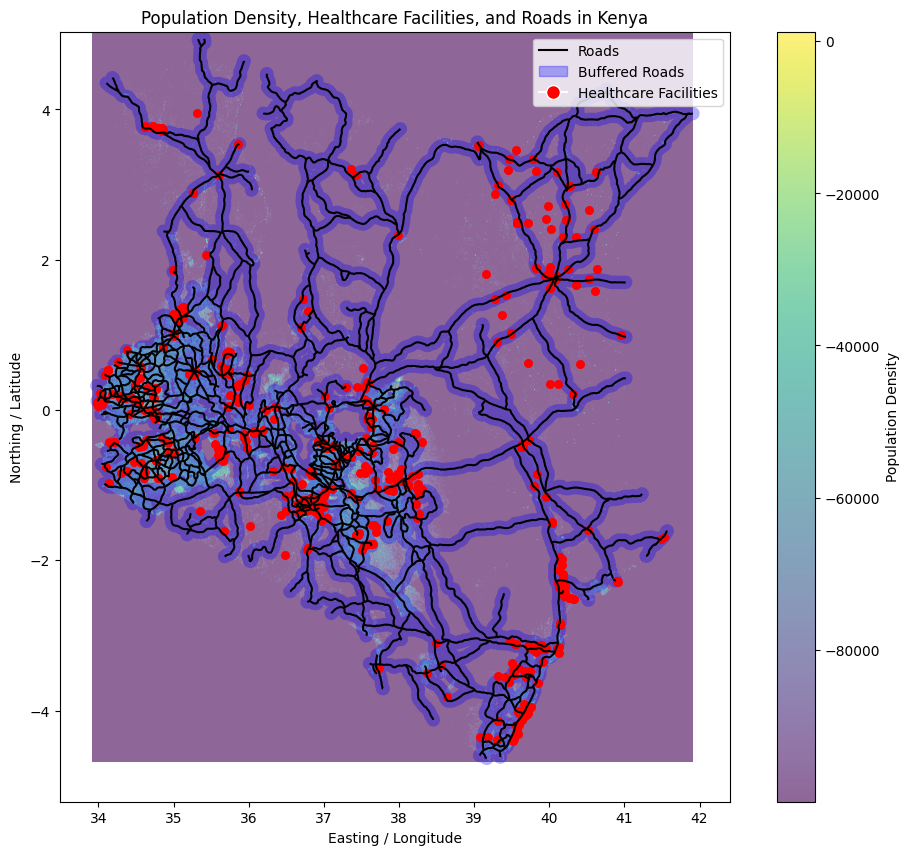

In [28]:
facilities_gdf = facilities_gdf.to_crs(raster_crs)
roads_gdf = roads_gdf.to_crs(raster_crs)

# -------------------------------
# Buffer Roads to Determine Accessibility
# -------------------------------
# Define the buffer distance in meters
buffer_distance = 10000

# Reproject roads to a projected CRS for correct buffering (EPSG:3857 uses meters)
roads_projected = roads_gdf.to_crs(epsg=3857)
roads_buffer = roads_projected.buffer(buffer_distance)
# Combine the buffers into one geometry using union_all (replaces deprecated unary_union)
roads_buffer_union = roads_buffer.union_all()
# Reproject the unioned buffer back to the raster's CRS
roads_buffer_union = gpd.GeoSeries(roads_buffer_union).set_crs(epsg=3857).to_crs(raster_crs)

# -------------------------------
# Identify Accessible Facilities
# -------------------------------
# Facilities that intersect with the buffered roads are considered accessible
accessible_facilities = facilities_gdf[facilities_gdf.intersects(roads_buffer_union)]
num_accessible = len(accessible_facilities)
print("Number of accessible healthcare facilities:", num_accessible)

# -------------------------------
# Plotting the Data
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the population density raster with correct extent
extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top]
img = ax.imshow(pop_density, extent=extent, cmap='viridis', alpha=0.6)
cbar = plt.colorbar(img, ax=ax)
cbar.set_label("Population Density")

# Plot roads as black lines
roads_gdf.plot(ax=ax, color='black', linewidth=1.5)

# Plot the buffered roads in blue with transparency
gpd.GeoSeries(roads_buffer_union).plot(ax=ax, color='blue', alpha=0.3)

# Plot all healthcare facilities as red dots
facilities_gdf.plot(ax=ax, marker='o', color='red', markersize=30)

# Create custom legend handles for clarity
road_handle = Line2D([0], [0], color='black', lw=1.5, label='Roads')
buffer_handle = Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='Buffered Roads')
facility_handle = Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                         markersize=10, label='Healthcare Facilities')

# Add the custom legend to the plot
ax.legend(handles=[road_handle, buffer_handle, facility_handle], loc='upper right')

ax.set_title("Population Density, Healthcare Facilities, and Roads in Kenya")
ax.set_xlabel("Easting / Longitude")
ax.set_ylabel("Northing / Latitude")

plt.show()